In [2]:
#Sentiment Analysis on IMDB Movie Reviews

*This project aims to classify movie reviews as **positive** or **negative** using machine learning. We use the IMDB dataset and multiple classification algorithms to compare performance and select the best.*

In [3]:
#Project Objective

*The goal of this project is to predict movie review sentiment using Natural Language Processing (NLP) and supervised learning models.*

In [1]:
#Libraries and Tools Used
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SOBIKUL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

*These libraries help with data loading, text preprocessing, visualization, vectorization, classification, evaluation, and tuning.*

In [3]:
#Load a random sample of 50,000 reviews from the IMDB dataset
load_dataset = pd.read_csv("IMDB Dataset.csv").sample(20000)
# Count the number of positive and negative reviews
load_dataset["sentiment"].value_counts()


sentiment
positive    10057
negative     9943
Name: count, dtype: int64

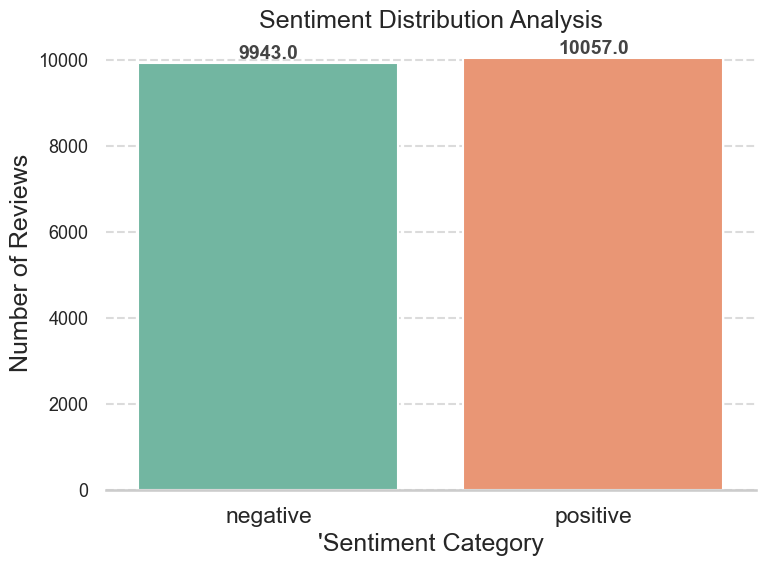

In [4]:
# Set Seaborn style and context for better plot aesthetics
sns.set_style("whitegrid")
sns.set_context("talk")
# Define custom color palette for the sentiment classes
color_palette =["#66c2a5","#fc8d62","8da0cb"]   
# Set up the figure and plot the sentiment distribution
plt.figure(figsize=(8,6))
bars = sns.countplot(x = "sentiment",data=load_dataset,palette=color_palette)
# Add chart title and axis labels
plt.title('Sentiment Distribution Analysis')
plt.xlabel("'Sentiment Category")
plt.ylabel("Number of Reviews")
# Annotate each bar with the actual count value
for bar in bars.patches:
        height = bar.get_height()
        bars.annotate(f'{height}', 
                  (bar.get_x() + bar.get_width() / 2, height), 
                  ha='center', va='bottom',
                  fontsize=14, fontweight='bold', color='#444444')
# Tweak the ticks and layout for better readability
plt.xticks(rotation=0)
plt.yticks(fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True)
# Show the final plot
plt.tight_layout()
plt.show()

In [5]:
# Extract all positive reviews from the dataset and convert them into a list.
pre_rievw =list(load_dataset[load_dataset["sentiment"] == "positive"] ["review"])

*The most prominent words like movie, character, love, and great appear larger because they are used most frequently in positive reviews. This visualization gives a quick insight into which words are most associated with positive sentiments. It helps us understand what users value most in movies they like, such as strong stories and emotional connections. Such wordclouds are very useful in exploratory text analysis for identifying patterns in sentiment data.*

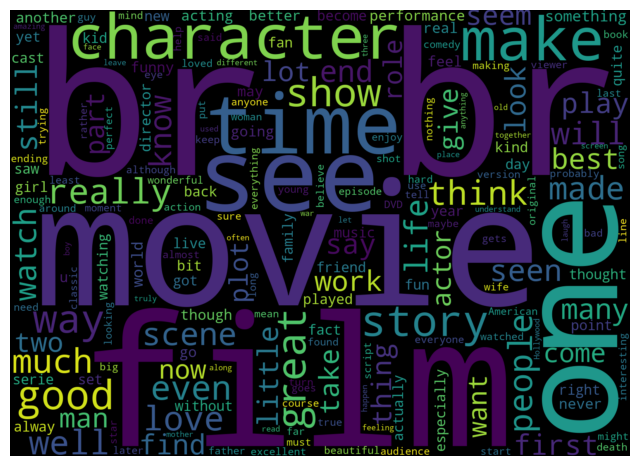

In [6]:
def create_review(string,titel = None):
    cloud = WordCloud(
        height=1080,
        width=1500,
        background_color="black",
        min_font_size=10,
        stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(8,6))
    plt.imshow(cloud,interpolation="bilinear")
    plt.axis("off")
create_review("".join(pre_rievw),"Word for postive reivew")

*Frequently used words such as film, one, bad, plot, and character dominate the cloud, indicating common points of criticism. This helps uncover repeated dissatisfaction or pain points in viewer feedback. It reveals how viewers express negative sentiments toward aspects like storyline, direction, or performance. The WordCloud offers a quick and intuitive summary of what viewers disliked most.*

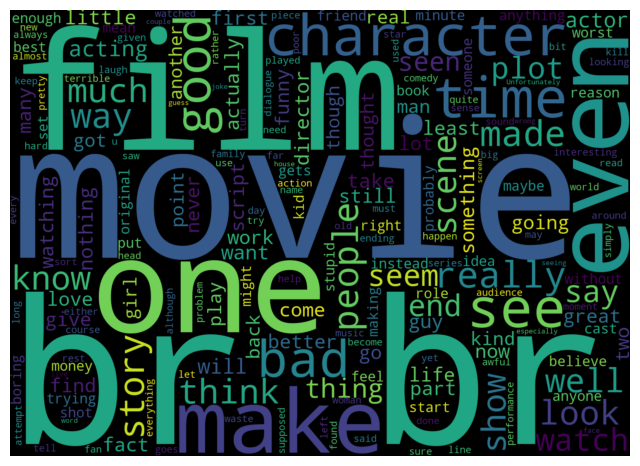

In [11]:
neg_rievw =list(load_dataset[load_dataset["sentiment"] == "negative"] ["review"])
create_review("".join(neg_rievw),"Word for negitive reivew")

In [ ]:
# Define stopwords: includes NLTK's stopwords and domain-specific movie terms.
stop_word =STOPWORDS
stop_words = set(stopwords.words('english'))
custom_stopwords = {"movie", "film", "cinema", "director", "actor", "scene", "character"}
final_stopwords = stop_words.union(custom_stopwords)
# Dictionary for expanding contractions.
contractions_dict = {
    "can't": "can not",
    "won't": "will not",
    "i'm": "i am",
    "it's": "it is",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "don't": "do not",
    "doesn't": "does not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "couldn't": "could not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "let's": "let us",
    "there's": "there is",
    "who's": "who is",
    "what's": "what is",
    "that's": "that is"
}

def text_preprocessing(review):
    preproces_reviwe =[]
     # Lowercase the review.
    text = review.lower()
    # Expand contractions using regex.
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: contractions_dict[x.group()], text)
    # Remove repeated characters like 'soooo' → 'soo'.
    text =re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Remove HTML tags, digits, and extra spaces.
    text =re.sub(r'<br\s*/?>', ' ', text)
    text = re.sub(r"\d+", '', text)
    text = re.sub(r"<[^>]+>", '', text)
    text =re.sub(' +', ' ', text)
    # Replace 'not <word>' with 'not_<word>' to combine negation with the following word as a single token.
    text = re.sub(r'not\s+(\w+)', r'not_\1', text)
    # Remove email addresses, URLs, mentions.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    # Remove non-ASCII and short words (1–2 letters).
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\b\w{1,2}\b', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Replace contractions in text with their expanded forms using the contractions dictionary.
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    text = pattern.sub(lambda x: contractions_dict[x.group()], text)
     # Handle negations (e.g., "not good" → "not_good").
    text = re.sub(r'\b(not|never|no)\s+(\w+)', r'\1_\2', text)
     # Step 8: Remove stopwords and lemmatize.
    words = [word for word in text.split() if word not in final_stopwords and len(word) > 2]
    preproces_reviwe.append(words)
    lammatizaer =WordNetLemmatizer() 
    temmed = [lammatizaer.lemmatize(word) for word in words]
    return " ".join(temmed)
load_dataset["clean_review"] = load_dataset["review"].apply(text_preprocessing)

In [13]:
# Encode the 'sentiment' column labels into numeric values using LabelEncoder.
le = LabelEncoder()
load_dataset.sentiment = le.fit_transform(load_dataset.sentiment)

In [14]:
# Split the dataset into training and testing sets (80% train, 20% test) for features (clean_review) and labels (sentiment).
x = load_dataset["clean_review"]
y = load_dataset["sentiment"]
x_train,x_test,y_train,y_test =train_test_split(x,y,test_size=.20,random_state=30)

In [15]:
# Convert text data into TF-IDF features using unigrams, bigrams, and trigrams, limiting to top 3000 features and removing English stopwords.
vce =TfidfVectorizer(max_features=3000,ngram_range=(1,3),stop_words='english')
x_train_vce=vce.fit_transform(x_train)
x_test_vec = vce.transform(x_test)

In [16]:
# Define hyperparameter grids for multiple classifiers and instantiate corresponding model objects for tuning and evaluation
def get_param_grids():
    return {
        "LogisticRegression": {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'max_iter': [100, 200]
        },
        "GradientBoostingClassifier": {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5]
        },
        "SVC": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
        "RandomForestClassifier": {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20]
        },
        "MultinomialNB": {
            'alpha': [0.5, 1.0, 1.5],
            'fit_prior': [True, False]
        }
    }

models ={
    "LogisticRegression":LogisticRegression(),
    "MultinomialNB":MultinomialNB(),
    "RandomForestClassifier":RandomForestClassifier(),
    "SVC":SVC(),
    "GradientBoostingClassifier": GradientBoostingClassifier()
}
param_grids = get_param_grids()

In [17]:
 # Initialize variable to keep track of the best cross-validation score.
best_score = 0
# Initialize variable to store the name of the best model.
best_model_bname = None
 # Initialize variable to store the best model estimator.
best_model = None
# Loop over each model in the models dictionary.
for name, model in models.items():
    # Print the current model being trained and tuned.
    print(f"\nTuning and training {name}...")
    # Get the hyperparameter grid for the current model.
    param_grid = param_grids[name]
    # Set up grid search with 5-fold CV.
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    # Fit the grid search on the training data.
    grid_search.fit(x_train_vce, y_train)
    # Get the best estimator found by grid search.
    best_estimator = grid_search.best_estimator_
    # Print the best hyperparameters.
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    # Print best CV accuracy.
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    # Predict on the test set using best estimator.
    y_pred = best_estimator.predict(x_test_vec)
    # Calculate test accuracy.
    test_acc = accuracy_score(y_test, y_pred)
    # Generate classification report.
    class_rep = classification_report(y_test, y_pred)
    # Compute confusion matrix.
    conf_mat = confusion_matrix(y_test, y_pred)
    # Calculate F1 score.
    f1_sc = f1_score(y_test, y_pred)
    # Print test accuracy.
    print(f"Test Accuracy for {name}: {test_acc:.4f}")
    # Print Classification Report.
    print(f"Classification Report:\n{class_rep}")
    # Print Confusion Matrix.
    print(f"Confusion Matrix:\n{conf_mat}")
    # Print F1 Score.
    print(f"F1 Score: {f1_sc:.4f}")
    # Update the best model if current model's CV score is better.
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model_name = name
        best_model = best_estimator
# Print header for best model info.
print("\nOverall Best Model:")
# Print name of the best model.
print(f"Model Name: {best_model_name}")
# Print best cross-validation score.
print(f"Best Cross-validation Score: {best_score:.4f}")


Tuning and training LogisticRegression...
Best parameters for LogisticRegression: {'C': 1, 'max_iter': 100, 'penalty': 'l2'}
Best cross-validation accuracy: 0.8738
Test Accuracy for LogisticRegression: 0.8682
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1995
           1       0.86      0.88      0.87      2005

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000

Confusion Matrix:
[[1702  293]
 [ 234 1771]]
F1 Score: 0.8705

Tuning and training MultinomialNB...
Best parameters for MultinomialNB: {'alpha': 1.5, 'fit_prior': False}
Best cross-validation accuracy: 0.8521
Test Accuracy for MultinomialNB: 0.8420
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1995
           1       0.84      0.85      0.84      2005

    